In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
# NVIDIA GPU ve CUDA bilgilerinizi görmek için:
!nvidia-smi

Tue Apr  8 16:13:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
!rm -rf rapidsai-csp-utils
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 587, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 587 (delta 122), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (587/587), 192.90 KiB | 2.47 MiB/s, done.
Resolving deltas: 100% (296/296), done.


In [4]:
!bash rapidsai-csp-utils/colab/rapids-colab.sh

PLEASE READ FOR 21.06
********************************************************************************************************
Another release, another script change.  We had to revise the script, which now:
1. Does a more comprehensive install
2. Includes BlazingSQL
3. is far easier for everyone to understand and maintain

The script will require you to add these 5 cells to your notebook.  We have also created a new startup template: 
https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9?usp=sharing

CHANGES T
CELL 1:
    # This get the RAPIDS-Colab install files and test check your GPU.  Run cells 1 and 2 only.
    # Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
    !python rapidsai-csp-utils/colab/env-check.py

CELL 2:
    # This will update the Colab environment and restart the kernel.
    !bash rapidsai-csp-

In [5]:
import cuml
print("RAPIDS cuML version:", cuml.__version__)

RAPIDS cuML version: 25.02.01


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from cuml.svm import SVC as cuSVC
from sklearn.preprocessing import LabelEncoder

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/sift_train_features.csv')
test_df = pd.read_csv('/content/drive/MyDrive/sift_test_features.csv')

In [8]:
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values  # etiketler string şeklinde, örneğin 'A'
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [9]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

In [10]:
def train_and_evaluate(model, model_name, encoder):
    """
    Verilen modeli eğitim verileri üzerinde eğitir, test verileri üzerinden tahmin yapar
    ve modelin performansını Accuracy ile değerlendirip confusion matrix’i orijinal etiketlerle görüntüler.

    Parametreler:
    - model: fit ve predict metodlarına sahip makine öğrenimi modeli.
    - model_name: Modelin adı (çıktılarda gösterim amacıyla kullanılır).
    - encoder: LabelEncoder nesnesi; encoder.classes_ kullanılarak orijinal etiketler elde edilir.
    """
    # Modeli eğitim verileri ile eğit (sayısallaştırılmış etiketler kullanılıyor)
    model.fit(X_train, y_train)

    # Test verisi üzerinden tahmin yap
    y_pred = model.predict(X_test)

    # Accuracy hesaplama
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Karışıklık matrisini oluştur
    cm = confusion_matrix(y_test, y_pred)

    # LabelEncoder'dan orijinal harf etiketlerini alalım
    original_labels = encoder.classes_

    # Karışıklık matrisini görselleştir
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=original_labels,
                yticklabels=original_labels)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Tahmin Edilen Etiket")
    plt.ylabel("Gerçek Etiket")
    plt.show()


In [11]:
gamma_value = 1 / (X_train.shape[1] * np.var(X_train))

cuML SVM Accuracy: 0.6764


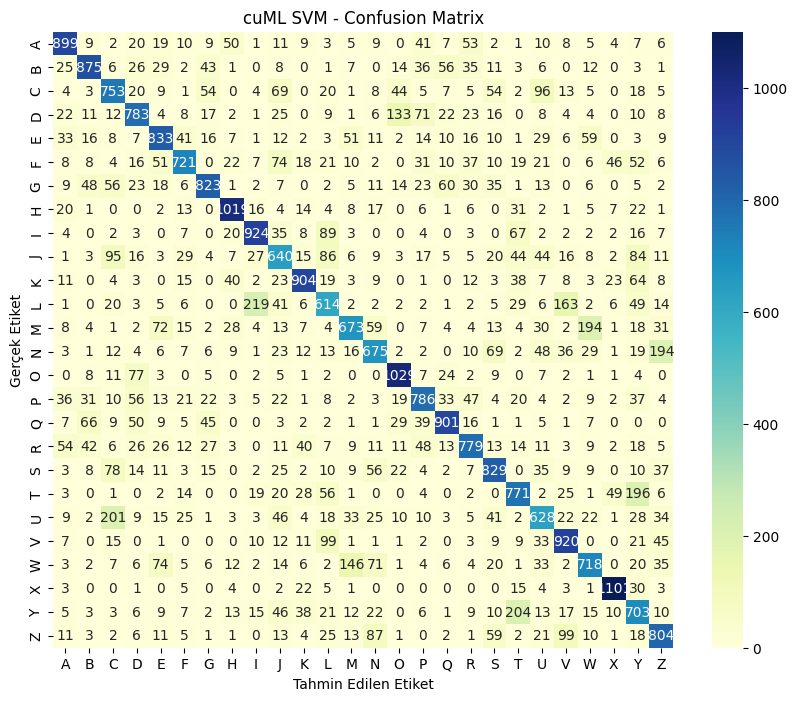

In [12]:
svm_gpu = cuSVC(C=1.0, kernel='rbf', gamma=gamma_value)
train_and_evaluate(svm_gpu, "cuML SVM", le)

In [13]:
train_df = pd.read_csv('/content/drive/MyDrive/sift_128_train_features.csv')
test_df = pd.read_csv('/content/drive/MyDrive/sift_128_test_features.csv')

In [14]:
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values  # etiketler string şeklinde, örneğin 'A'
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [15]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

In [16]:
def train_and_evaluate(model, model_name, encoder):
    """
    Verilen modeli eğitim verileri üzerinde eğitir, test verileri üzerinden tahmin yapar
    ve modelin performansını Accuracy ile değerlendirip confusion matrix’i orijinal etiketlerle görüntüler.

    Parametreler:
    - model: fit ve predict metodlarına sahip makine öğrenimi modeli.
    - model_name: Modelin adı (çıktılarda gösterim amacıyla kullanılır).
    - encoder: LabelEncoder nesnesi; encoder.classes_ kullanılarak orijinal etiketler elde edilir.
    """
    # Modeli eğitim verileri ile eğit (sayısallaştırılmış etiketler kullanılıyor)
    model.fit(X_train, y_train)

    # Test verisi üzerinden tahmin yap
    y_pred = model.predict(X_test)

    # Accuracy hesaplama
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Karışıklık matrisini oluştur
    cm = confusion_matrix(y_test, y_pred)

    # LabelEncoder'dan orijinal harf etiketlerini alalım
    original_labels = encoder.classes_

    # Karışıklık matrisini görselleştir
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=original_labels,
                yticklabels=original_labels)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Tahmin Edilen Etiket")
    plt.ylabel("Gerçek Etiket")
    plt.show()

In [17]:
gamma_value = 1 / (X_train.shape[1] * np.var(X_train))

cuML SVM Accuracy: 0.6204


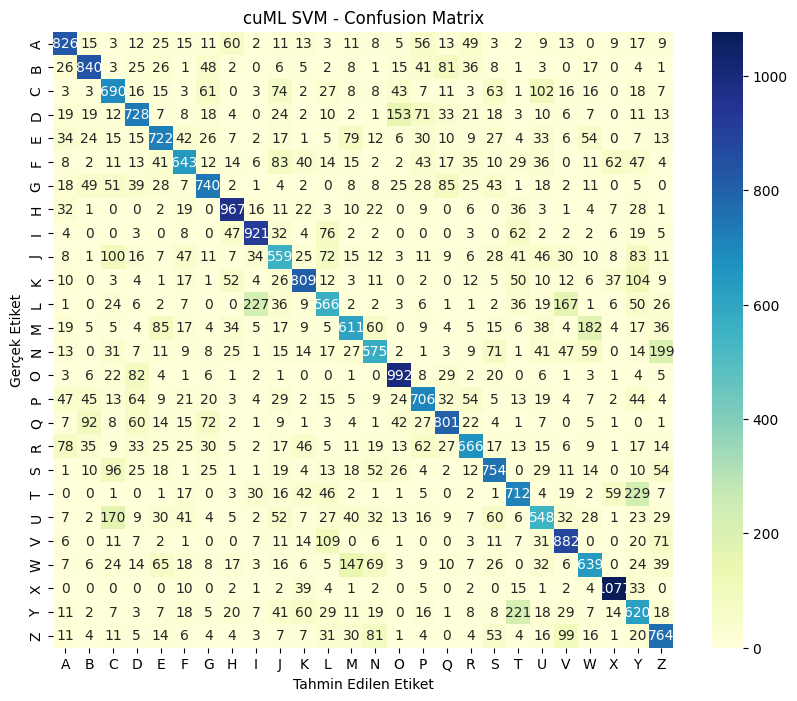

In [18]:
svm_gpu = cuSVC(C=1.0, kernel='rbf', gamma=gamma_value)
train_and_evaluate(svm_gpu, "cuML SVM", le)

In [20]:
train_df = pd.read_csv('/content/drive/MyDrive/sift_512_train_features.csv')
test_df = pd.read_csv('/content/drive/MyDrive/sift_512_test_features.csv')

In [21]:
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values  # etiketler string şeklinde, örneğin 'A'
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [22]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

In [23]:
def train_and_evaluate(model, model_name, encoder):
    """
    Verilen modeli eğitim verileri üzerinde eğitir, test verileri üzerinden tahmin yapar
    ve modelin performansını Accuracy ile değerlendirip confusion matrix’i orijinal etiketlerle görüntüler.

    Parametreler:
    - model: fit ve predict metodlarına sahip makine öğrenimi modeli.
    - model_name: Modelin adı (çıktılarda gösterim amacıyla kullanılır).
    - encoder: LabelEncoder nesnesi; encoder.classes_ kullanılarak orijinal etiketler elde edilir.
    """
    # Modeli eğitim verileri ile eğit (sayısallaştırılmış etiketler kullanılıyor)
    model.fit(X_train, y_train)

    # Test verisi üzerinden tahmin yap
    y_pred = model.predict(X_test)

    # Accuracy hesaplama
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Karışıklık matrisini oluştur
    cm = confusion_matrix(y_test, y_pred)

    # LabelEncoder'dan orijinal harf etiketlerini alalım
    original_labels = encoder.classes_

    # Karışıklık matrisini görselleştir
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=original_labels,
                yticklabels=original_labels)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Tahmin Edilen Etiket")
    plt.ylabel("Gerçek Etiket")
    plt.show()

In [24]:
gamma_value = 1 / (X_train.shape[1] * np.var(X_train))

cuML SVM Accuracy: 0.7102


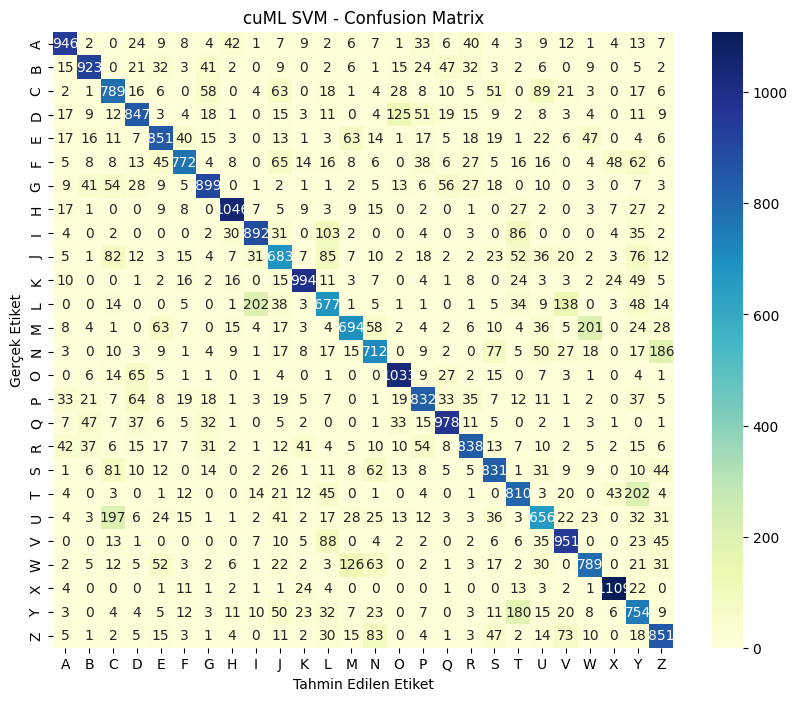

In [25]:
svm_gpu = cuSVC(C=1.0, kernel='rbf', gamma=gamma_value)
train_and_evaluate(svm_gpu, "cuML SVM", le)

In [26]:
train_df = pd.read_csv('/content/drive/MyDrive/hog_train_features.csv')
test_df = pd.read_csv('/content/drive/MyDrive/hog_test_features.csv')

In [27]:
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values  # etiketler string şeklinde, örneğin 'A'
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [28]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

In [29]:
def train_and_evaluate(model, model_name, encoder):
    """
    Verilen modeli eğitim verileri üzerinde eğitir, test verileri üzerinden tahmin yapar
    ve modelin performansını Accuracy ile değerlendirip confusion matrix’i orijinal etiketlerle görüntüler.

    Parametreler:
    - model: fit ve predict metodlarına sahip makine öğrenimi modeli.
    - model_name: Modelin adı (çıktılarda gösterim amacıyla kullanılır).
    - encoder: LabelEncoder nesnesi; encoder.classes_ kullanılarak orijinal etiketler elde edilir.
    """
    # Modeli eğitim verileri ile eğit (sayısallaştırılmış etiketler kullanılıyor)
    model.fit(X_train, y_train)

    # Test verisi üzerinden tahmin yap
    y_pred = model.predict(X_test)

    # Accuracy hesaplama
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Karışıklık matrisini oluştur
    cm = confusion_matrix(y_test, y_pred)

    # LabelEncoder'dan orijinal harf etiketlerini alalım
    original_labels = encoder.classes_

    # Karışıklık matrisini görselleştir
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=original_labels,
                yticklabels=original_labels)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Tahmin Edilen Etiket")
    plt.ylabel("Gerçek Etiket")
    plt.show()

In [30]:
gamma_value = 1 / (X_train.shape[1] * np.var(X_train))

cuML SVM Accuracy: 0.9436


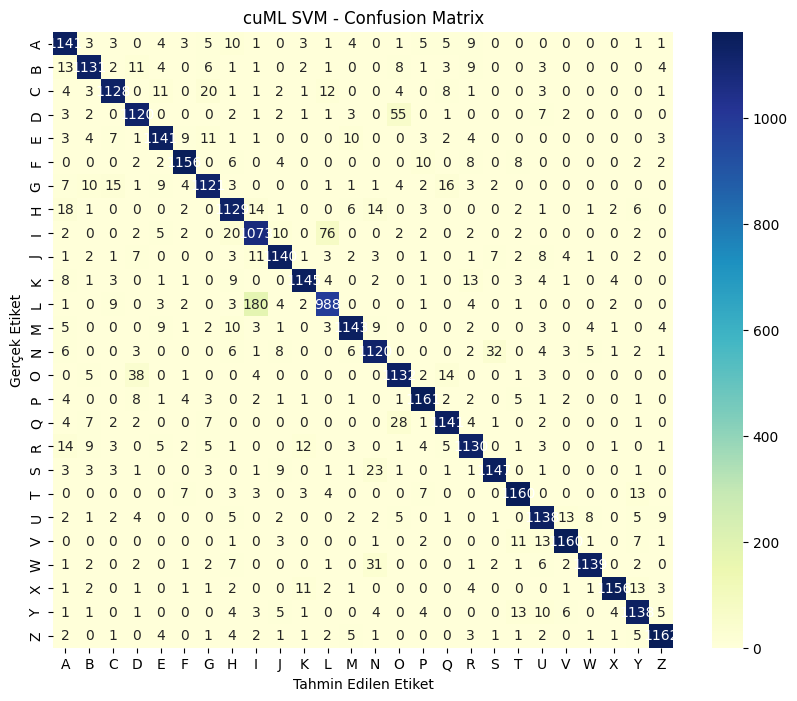

In [31]:
svm_gpu = cuSVC(C=1.0, kernel='rbf', gamma=gamma_value)
train_and_evaluate(svm_gpu, "cuML SVM", le)